In [1]:
import torch

print("CUDA available:", torch.cuda.is_available())

print("Current device:", torch.cuda.current_device())
print("Device name:", torch.cuda.get_device_name(torch.cuda.current_device()))

CUDA available: True
Current device: 0
Device name: NVIDIA GeForce GTX 1650


In [2]:
import pandas as pd
import numpy as np
import re

from sklearn.model_selection import train_test_split
from sklearn.preprocessing import LabelEncoder
from sklearn.ensemble import RandomForestClassifier
from sklearn.metrics import classification_report, accuracy_score

In [7]:
data=pd.read_excel('merged.xlsx')

In [8]:
data.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 24665 entries, 0 to 24664
Data columns (total 33 columns):
 #   Column       Non-Null Count  Dtype  
---  ------       --------------  -----  
 0   청구서번호        24664 non-null  object 
 1   No.          24664 non-null  float64
 2   Subject      24642 non-null  object 
 3   Machinery    24664 non-null  object 
 4   Assembly     24664 non-null  object 
 5   청구품목         24664 non-null  object 
 6   Unnamed: 6   0 non-null      float64
 7   Part No.1    24640 non-null  object 
 8   Part No.2    3599 non-null   object 
 9   청구량          24546 non-null  float64
 10  견적           24200 non-null  object 
 11  Unnamed: 11  7737 non-null   float64
 12  견적수량         16809 non-null  float64
 13  견적화폐         24546 non-null  object 
 14  견적단가         24664 non-null  float64
 15  발주번호         24664 non-null  object 
 16  발주처          24546 non-null  object 
 17  발주           24546 non-null  object 
 18  발주수량         24546 non-null  float64
 19  발주금액

In [12]:
#창고 입고일은 있는데, 발주일자가 누락된 경우 => 발주처 및 발주번호를 통해 결측값 채워 넣기
missing_both = data[data['창고입고'].notnull() & data['발주'].isnull()]

print(f"창고 입고일은 있는데, 발주일자가 누락된 경우: {len(missing_both)}개")

창고 입고일은 있는데, 발주일자가 누락된 경우: 118개


In [13]:
missing_conditions = data[
    data['발주'].notnull() &  # 발주 일자는 비어있지 않음
    data['미입고 기간'].isnull() &  # 미입고 기간은 비어있음
    data['창고입고'].isnull() & # 창고 입고도 비어있음
    data['선박입고'].isnull()  # 선박 입고도 비어있음

]

print(f"발주 일자는 있지만 미입고 기간, 창고 입고, 선박 입고도 없는 경우: {len(missing_conditions)}개")

발주 일자는 있지만 미입고 기간, 창고 입고, 선박 입고도 없는 경우: 1699개


In [14]:
df=pd.read_excel('dataset0828.xlsx')

In [15]:
#창고 입고일은 있는데, 발주일자가 누락된 경우 => 발주처 및 발주번호를 통해 결측값 채워 넣음.
missing_both = df[df['창고입고'].notnull() & df['발주'].isnull()]

print(f"창고 입고일은 있는데, 발주일자가 누락된 경우: {len(missing_both)}개")

창고 입고일은 있는데, 발주일자가 누락된 경우: 0개


In [16]:
#발주 일자는 있는데, 미입고 기간도 없고 창고 입고도 없고 선박입고도 없음
missing_conditions = df[
    df['발주'].notnull() &  # 발주 일자는 비어있지 않음
    df['미입고 기간'].isnull() &  # 미입고 기간은 비어있음
    df['창고입고'].isnull() & # 창고 입고도 비어있음
    df['선박입고'].isnull()  # 선박 입고도 비어있음

]

print(f"발주 일자는 있지만 미입고 기간, 창고 입고, 선박 입고도 없는 경우: {len(missing_conditions)}개")

발주 일자는 있지만 미입고 기간, 창고 입고, 선박 입고도 없는 경우: 1699개


In [19]:
#미입고기간으로 처리.
missing_both = df[df['창고입고'].isnull() & df['미입고 기간'].notnull()]

print(f"창고 입고일은 없고 미입고 기간은 명시되어 있어 미입고 기간으로 처리해야 할 경우 : {len(missing_both)}개")

창고 입고일은 없고 미입고 기간은 명시되어 있어 미입고 기간으로 처리해야 할 경우 : 1620개


### 발주 일자는 있지만 미입고 기간, 창고 입고, 선박 입고도 없는 경우 drop

In [20]:
missing_conditions = df[
    df['발주'].notnull() &  
    df['미입고 기간'].isnull() &  
    df['창고입고'].isnull() &  
    df['선박입고'].isnull() 
]

df_cleaned = df.drop(missing_conditions.index)

print(f"삭제된 행의 개수: {len(missing_conditions)}개")
print(f"새로운 데이터프레임 크기: {df_cleaned.shape}")

삭제된 행의 개수: 1699개
새로운 데이터프레임 크기: (22965, 32)


### TODO: 창고 입고와 발주 날짜가 같은 데이터에 대한 처리

In [45]:
df['발주'] = pd.to_datetime(df['발주'])
df['창고입고'] = pd.to_datetime(df['창고입고'])

same_date_df = df[df['발주'] == df['창고입고']]

# 필터링된 행의 수를 세기
count_same_date = same_date_df.shape[0]

print(f"창고입고와 발주 날짜가 같은 행의 개수: {count_same_date}")

창고입고와 발주 날짜가 같은 행의 개수: 292


In [41]:
df['발주'] = pd.to_datetime(df['발주'], errors='coerce')
df['창고입고'] = pd.to_datetime(df['창고입고'], errors='coerce')

df['leadtime'] = df.apply(
    lambda row: (row['창고입고'] - row['발주']).days if pd.notna(row['창고입고']) else 112, 
    axis=1
)

print(df[['발주', '창고입고', 'leadtime']].head())

          발주       창고입고  leadtime
0 2019-01-11 2019-05-03       112
1 2019-01-11 2019-04-18        97
2 2019-01-11 2019-05-03       112
3 2019-04-01 2019-04-01         0
4 2019-04-01 2019-04-01         0


In [48]:
df = pd.read_excel('data_cleaned.xlsx')


<class 'pandas.core.frame.DataFrame'>
RangeIndex: 22965 entries, 0 to 22964
Data columns (total 32 columns):
 #   Column       Non-Null Count  Dtype  
---  ------       --------------  -----  
 0   청구서번호        22965 non-null  object 
 1   No.          22965 non-null  int64  
 2   Subject      22943 non-null  object 
 3   Machinery    22965 non-null  object 
 4   Assembly     22965 non-null  object 
 5   청구품목         22965 non-null  object 
 6   Unnamed: 6   0 non-null      float64
 7   Part No.1    22947 non-null  object 
 8   Part No.2    3330 non-null   object 
 9   청구량          22847 non-null  float64
 10  견적           22557 non-null  object 
 11  견적수량         22847 non-null  float64
 12  견적화폐         22847 non-null  object 
 13  견적단가         22965 non-null  float64
 14  발주번호         22965 non-null  object 
 15  발주처          22965 non-null  object 
 16  발주           22965 non-null  object 
 17  발주수량         22847 non-null  float64
 18  발주금액         22847 non-null  float64
 19  D/T 

## 미입고 기간 예측 (분류) 
> 1개월, 3개월, 6개월, 6개월 초과 등의 범주형 값

## 리드타임 예측 (회귀) 

> 오타, 변형 서브워드로 처리하기 위해 fasttext 임베딩
> 발주처 (79)는 카테고리 임베딩 => 따로 처리해서 결합하여 사용

In [24]:
import pandas as pd
import numpy as np
import re

from sklearn.model_selection import train_test_split
from sklearn.preprocessing import LabelEncoder
from sklearn.ensemble import RandomForestClassifier
from sklearn.metrics import classification_report, accuracy_score

### 품목 / 발주처 텍스트 전처리

In [61]:
import re

def preprocess_text(text):
    # 괄호 안의 내용 제거
    text = re.sub(r'\([^)]*\)', '', text)  
    # 알파벳, 숫자, 필요한 특수문자 (/, *, -, +, ., ,, #, &, 등)만 허용
    text = re.sub(r'[^\w\s\*/\-\+.,#&]', '', text) 
    # 여러 공백을 언더스코어로 변환
    text = re.sub(r'\s+', '_', text)
    # 텍스트 중간의 연속된 언더스코어를 하나로 줄임
    text = re.sub(r'_+', '_', text) 
    # 불필요한 단어 제거
    text = re.sub(r'\b(사용금지|사)\b', '', text, flags=re.IGNORECASE)
    # 중간에 언더스코어가 불필요하게 남아있는 경우 처리
    text = re.sub(r'(?<!\w)_(?!\w)', '', text)
    # 언더스코어 앞뒤로 존재하는 특수문자 제거
    text = re.sub(r'_([^\w]+)_', '_', text)
    text = re.sub(r'_([^\w]+)$', '', text)
    text = re.sub(r'^([^\w]+)_', '', text)
    # 텍스트 끝부분의 불필요한 언더스코어 제거
    text = re.sub(r'_+$', '', text)
    # 영어 단어는 소문자로 변환
    text = ' '.join([word.lower() if re.match(r'[A-Za-z]', word) else word for word in text.split()])
    text = text.strip()
    return text

def clean_supplier_name(name):
    # 접미사 제거
    suffixes = r'\b(Corp\.?|Corporation|Company|Co\.?|Incorporated|Inc\.?|Limited|Ltd\.?|GmbH|S\.L\.|SDN\. BHD\.)\b'
    name = re.sub(suffixes, '', name, flags=re.IGNORECASE)
    # 특수 문자 제거
    name = re.sub(r'[^\w\s]', '', name)
    # 불필요한 단어 제거
    name = re.sub(r'\b(사용금지|사)\b', '', name, flags=re.IGNORECASE)
    # 공백 정리
    name = re.sub(r'\s+', ' ', name).strip()
    # 오타 수정 및 문자열 정리
    name = re.sub(r'coporation|coropration|coproration|corporration', 'corporation', name, flags=re.IGNORECASE)
    name = name.lower().strip()
    return name

In [72]:
# 각 칼럼 전처리
df['cleaned_machinery'] = df['Machinery'].apply(preprocess_text)
df['cleaned_assembly'] = df['Assembly'].apply(preprocess_text)
df['cleaned_item'] = df['청구품목'].apply(preprocess_text)
df['Part No.1'] = df['Part No.1'].astype(str)
df['cleaned_part'] = df['Part No.1'].apply(preprocess_text)

df['cleaned_supplier'] = df['발주처'].apply(clean_supplier_name)

# 전처리된 칼럼 결합
df['combined_text'] = df['cleaned_machinery'].fillna('') + " " + df['cleaned_assembly'].fillna('') + " " + df['cleaned_item'].fillna('') + " " + df['cleaned_part'].fillna('') 

In [63]:
print(df['combined_text'])

0        cargo_boom_vang_block block mckissick_construc...
1        spanish_boom_vang_block block mckissick_constr...
2        purse_block tow_block westec_20ton_tow_block w...
3        main_engine power_pack_as ge_power_pack_fork_e...
4        main_engine power_pack_as ge_power_pack_fork_e...
                               ...                        
22960    main_engine crankshaft,_flywheel_and_vibration...
22961    main_engine air_filter_with_silencer_installat...
22962    main_engine air_filter_with_silencer_installat...
22963    main_engine air_filter_with_silencer_installat...
22964    main_engine air_filter_with_silencer_installat...
Name: combined_text, Length: 22965, dtype: object


### 품목명 임베딩 fasttext (param 조정)

> 전체 텍스트 임베딩 전, 상관관계 분석으로 가중치 줄 칼럼 선택하기

> 각각의 텍스트 카테고리별로 별도의 FastText 모델 훈련하고 각각의 임베딩 생성

> 상관관계 분석 / 주성분 분석

In [85]:
from gensim.models import FastText

# 각 칼럼에 대해 별도의 모델 학습
def train_fasttext_model(text_column):
    sentences = [text.split() for text in df[text_column]]
    model = FastText(vector_size=100, window=5, min_count=1, min_n=3, max_n=6, sg=1)
    model.build_vocab(sentences)
    model.train(sentences, total_examples=len(sentences), epochs=10)
    return model

# 각 칼럼에 대한 모델 훈련
models = {
    'machinery': train_fasttext_model('cleaned_machinery'),
    'assembly': train_fasttext_model('cleaned_assembly'),
    'item': train_fasttext_model('cleaned_item'),
    'part': train_fasttext_model('cleaned_part'),
    'supplier':train_fasttext_model('cleaned_supplier']
    df['cleaned_supplier'] = df['발주처'].apply(clean_supplier_name)

}

# 임베딩 생성
def get_embedding(text, model):
    words = text.split()
    word_vectors = [model.wv[word] for word in words if word in model.wv]
    if word_vectors:
        return np.mean(word_vectors, axis=0)  # NumPy 배열의 평균
    else:
        return np.zeros(model.vector_size)

# 각 칼럼별 임베딩의 평균값 계산
df['machinery_embedding_mean'] = df['embedding_machinery'].apply(lambda x: np.mean(x) if len(x) == embedding_dim else np.nan)
df['assembly_embedding_mean'] = df['embedding_assembly'].apply(lambda x: np.mean(x) if len(x) == embedding_dim else np.nan)
df['item_embedding_mean'] = df['embedding_item'].apply(lambda x: np.mean(x) if len(x) == embedding_dim else np.nan)
df['part_embedding_mean'] = df['embedding_part'].apply(lambda x: np.mean(x) if len(x) == embedding_dim else np.nan)


SyntaxError: closing parenthesis ']' does not match opening parenthesis '(' (937754664.py, line 17)

In [59]:
print(df.columns)


Index(['청구서번호', 'No.', 'Subject', 'Machinery', 'Assembly', '청구품목',
       'Unnamed: 6', 'Part No.1', 'Part No.2', '청구량', '견적', '견적수량', '견적화폐',
       '견적단가', '발주번호', '발주처', '발주', '발주수량', '발주금액', 'D/T', '미입고 기간', '창고입고',
       '창고입고수량', 'Control No.', '입고창고', '창고출고', '창고출고수량', '출고선박', '출고운반선',
       '선박입고', '선박입고수량', '완료 여부', 'leadtime'],
      dtype='object')


In [74]:
df['발주'] = pd.to_datetime(df['발주'], errors='coerce')
df['창고입고'] = pd.to_datetime(df['창고입고'], errors='coerce')

df['leadtime'] = df.apply(
    lambda row: (row['창고입고'] - row['발주']).days if pd.notna(row['창고입고']) else 112, 
    axis=1
)

print(df[['발주', '창고입고', 'leadtime']].head())

          발주       창고입고  leadtime
0 2019-01-11 2019-05-03       112
1 2019-01-11 2019-04-18        97
2 2019-01-11 2019-05-03       112
3 2019-04-01 2019-04-01         0
4 2019-04-01 2019-04-01         0


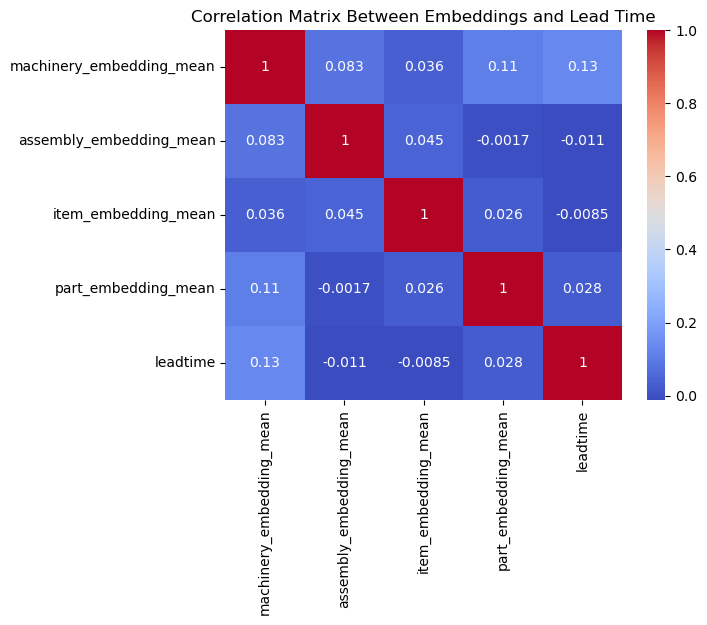

In [75]:
# leadtime과의 상관관계를 보기 위한 데이터프레임 준비
correlation_df = df[['machinery_embedding_mean', 'assembly_embedding_mean', 'item_embedding_mean', 'part_embedding_mean', 'leadtime']]

# 상관관계 행렬 계산
correlation_matrix = correlation_df.corr()

# 상관관계 행렬 시각화
sns.heatmap(correlation_matrix, annot=True, cmap='coolwarm')
plt.title('Correlation Matrix Between Embeddings and Lead Time')
plt.show()